Lost Deliveries Impact Model 
--

1. Use first 28 days to get features, label should be from the next 28 days.
2. 28 days should not use the same start and end day for different users, the first day of the 28 days is the first time we observe a session from the user, then 28 days from this day.
3. When using Lasso, the features need to be normalized.
4. A classifiction model first, churned vs active.

In [1]:
import pandas as pd
import numpy as np
import re
import datetime
from matplotlib import pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.grid_search import GridSearchCV
from sklearn import linear_model
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
import statsmodels.api as sm
from datetime import datetime, timedelta
import pickle

%matplotlib inline

In [2]:
# Read in 28 days LDs and Orders
df_lds_orders_201809 = pd.read_pickle(\
    '/Users/jianhuitian/carrot/logistics/logistics-data-science/conversion_model_v1/lost_deliveries_v4/data/lds_orders_20180903_20180930.pkl')

df_lds_orders_201810 = pd.read_pickle(\
    '/Users/jianhuitian/carrot/logistics/logistics-data-science/conversion_model_v1/lost_deliveries_v4/data/lds_orders_20181001_20181028.pkl')

df_lds_orders_201811 = pd.read_pickle(\
    '/Users/jianhuitian/carrot/logistics/logistics-data-science/conversion_model_v1/lost_deliveries_v4/data/lds_orders_20181029_20181125.pkl')

# Read in user infos for users in this 28 days
user_infos = pd.read_pickle(\
'/Users/jianhuitian/carrot/logistics/logistics-data-science/conversion_model_v1/lost_deliveries_v4/data/user_info_20180903_20180930.pkl')


## Functions, Variables, etc.

In [3]:
user_type_map = {'new': 1, 'non_express': 2, 'free_express': 3, 'discount_express': 4, 'paid_express': 5}
user_type_map_reverse = {v:k for k,v in user_type_map.items()}

def get_orders(df):
    # df[['user_id', 'date', 'converted']]
    
    orders_per_day = df[['user_id', 'date', 'converted']]\
        .groupby(['user_id', 'date']).sum().reset_index()

    orders = orders_per_day[orders_per_day['converted'] != 0][['user_id', 'date']]\
        .groupby(['user_id']).count().reset_index().rename(columns={'date': 'order'})
    
    return orders 

def get_visits(df):
    # df[['user_id', 'date']]
    
    unique_visits = df[['user_id', 'date']]\
        .drop_duplicates()

    visits = unique_visits.groupby(['user_id']).count().reset_index()\
        .rename(columns={'date':'visit'})
    
    return visits

def get_num_warehouse(df):
    # df[['user_id', 'warehouse_id']]
    
    num_warehouse = df[['user_id', 'warehouse_id']]\
        .drop_duplicates()
    
    num_warehouse = num_warehouse.groupby(['user_id']).count().reset_index()\
        .rename(columns={'warehouse_id':'num_warehouse'})
    
    return num_warehouse

## Get user ids for study.

In [4]:
# Get all the user_ids during 20180903-20180930.
# Get the corresponding first_date and last_date.
# The 28 days period is based on this first_date and last_date for each of the users.

user_ids = df_lds_orders_201809[['user_id', 'date']]\
    .groupby(['user_id']).min().reset_index()\
    .rename(columns={'date':'first_date'})
user_ids['last_date'] = user_ids['first_date'].map(lambda x: x + timedelta(days=28)) 
user_ids['label_date'] = user_ids['last_date'].map(lambda x: x + timedelta(days=28)) 

In [5]:
user_ids.head(5)

,user_id,first_date,last_date,label_date
0,11,2018-09-03,2018-10-01,2018-10-29
1,22,2018-09-07,2018-10-05,2018-11-02
2,52,2018-09-10,2018-10-08,2018-11-05
3,59,2018-09-14,2018-10-12,2018-11-09
4,60,2018-09-04,2018-10-02,2018-10-30


## Get DataFrame For The First 28 Days.

In [6]:
df_lds_orders = pd.concat([df_lds_orders_201809, df_lds_orders_201810])
df_lds_orders = user_ids.merge(df_lds_orders, on=['user_id'], how='left')
df_lds_orders = df_lds_orders[df_lds_orders['date'] < df_lds_orders['last_date']]

### Check Data

In [7]:
df_lds_orders[df_lds_orders['user_id'] == 77][['user_id', 'date', 'last_date',\
              'hour', 'user_type', 'warehouse_id', 'metric_name', 
               'lost_estimate', 'converted']]

,user_id,date,last_date,hour,user_type,warehouse_id,metric_name,lost_estimate,converted
56,77,2018-09-12,2018-10-10,16,paid_express,3,lost_demand_precheckout,0.000000,False
57,77,2018-09-18,2018-10-10,5,paid_express,3,lost_demand_checkout,0.001170,True
58,77,2018-09-18,2018-10-10,5,paid_express,3,lost_demand_precheckout,0.065679,True
59,77,2018-09-22,2018-10-10,8,paid_express,53,lost_demand_checkout,0.009232,True
60,77,2018-09-22,2018-10-10,8,paid_express,3,lost_demand_precheckout,0.000000,True
61,77,2018-09-22,2018-10-10,8,paid_express,53,lost_demand_precheckout,0.000000,True
62,77,2018-09-27,2018-10-10,7,paid_express,53,lost_demand_precheckout,0.109320,False
63,77,2018-10-07,2018-10-10,15,paid_express,53,lost_demand_precheckout,0.000000,False
64,77,2018-10-08,2018-10-10,11,paid_express,53,lost_demand_precheckout,0.066558,False
65,77,2018-10-09,2018-10-10,11,paid_express,53,lost_demand_precheckout,0.000000,False


## Feature Engineering For LDs and Orders

In [8]:
# Get lost deliveries for this period.
user_lost_deliveries = df_lds_orders[['user_id', 'lost_estimate']]\
    .groupby('user_id').sum().reset_index()

# Get orders for this period.
user_orders = get_orders(df_lds_orders[['user_id', 'date', 'converted']])

# Get visits for the period.
user_visits = get_visits(df_lds_orders[['user_id', 'date']])

# Warehouse_id is unique and universal.
user_warehouse_daily_count = df_lds_orders[['user_id', 'date', 'warehouse_id']]\
    .drop_duplicates().groupby(['user_id', 'date']).count().reset_index()

user_warehouse_daily_average = user_warehouse_daily_count[['user_id', 'warehouse_id']]\
    .groupby('user_id').mean().reset_index().rename(columns={'warehouse_id':'warehouse_daily_avg'})

# Get the average visit interval days.
user_visit_feature = df_lds_orders[['user_id', 'date', 'last_date']]\
    .drop_duplicates().sort_values(by=['user_id', 'date'])
user_visit_feature['lag1'] = user_visit_feature.groupby('user_id')['date'].shift(-1)

def get_visit_interval(x0, x1, x2):
    if not x1:
        return (x2 - x0).days
    else:
        return (x1 - x0).days

user_visit_feature['visit_interval'] = user_visit_feature[['date', 'lag1', 'last_date']]\
    .apply(lambda x: get_visit_interval(x[0], x[1], x[2]), axis=1)
user_visit_feature.fillna(value={'visit_interval': 28}, inplace=True)

user_avg_visit_feature = user_visit_feature[['user_id', 'visit_interval']]\
    .groupby('user_id').mean().reset_index()

# About 7% of users have two user_types.
# User type at the beginning of the period
user_first_date = df_lds_orders[['user_id', 'date']].groupby(['user_id']).min().reset_index()
user_type_first = user_first_date.merge(df_lds_orders[['user_id', 'date', 'user_type']].drop_duplicates(),\
    on=['user_id', 'date'], how='left')\
    .drop(columns=['date'], axis=1)
user_type_first['user_type'] = user_type_first['user_type'].map(lambda x: user_type_map[x])
user_type_first = user_type_first.groupby('user_id').max().reset_index()

user_type_first_count = user_type_first.groupby('user_type')\
    .count().rename(columns={'user_id': 'count_first'}).reset_index()
user_type_first_count['user_type'] = user_type_first_count['user_type'].map(lambda x: user_type_map_reverse[x])

# User type at the end of the period
user_last_date = df_lds_orders[['user_id', 'date']].groupby(['user_id']).max().reset_index()
user_type_last = user_last_date.merge(df_lds_orders[['user_id', 'date', 'user_type']].drop_duplicates(),\
    on=['user_id', 'date'], how='left')\
    .drop(columns=['date'], axis=1)
user_type_last['user_type'] = user_type_last['user_type'].map(lambda x: user_type_map[x])
user_type_last = user_type_last.groupby('user_id').max().reset_index()

user_type_last_count = user_type_last.groupby('user_type')\
    .count().rename(columns={'user_id': 'count_last'}).reset_index()
user_type_last_count['user_type'] = user_type_last_count['user_type'].map(lambda x: user_type_map_reverse[x])

user_type_count = user_type_first_count\
    .merge(user_type_last_count, on=['user_type'])

# Get the number of warehouse during the period.
user_num_warehouse = get_num_warehouse(df_lds_orders[['user_id', 'warehouse_id']])

# Merge all the DataFrame after feature engineering.
user_df = user_lost_deliveries.merge(user_orders, on=['user_id'], how='left')
user_df = user_df.merge(user_visits, on=['user_id'])
user_df = user_df.merge(user_warehouse_daily_average, on=['user_id'], how='left')
user_df = user_df.merge(user_avg_visit_feature, on='user_id', how='left')
user_df = user_df.merge(user_num_warehouse, on=['user_id'], how='left')
user_df = user_df.merge(user_type_last, on='user_id', how='left')\
    .fillna(value={'order': 0})

## Get DataFrame For The Second 28 Days.

In [9]:
df_labels = pd.concat([df_lds_orders_201810, df_lds_orders_201811])
df_labels = user_ids.merge(df_labels, on=['user_id'], how='left')
df_labels = df_labels[(df_labels['date'] >= df_labels['last_date'])\
                      & (df_labels['date'] < df_labels['label_date'])]

## Feature Engineers For Labels

In [10]:
# Get orders for this period.
label_orders = get_orders(df_labels[['user_id', 'date', 'converted']])

# Get visits for the period, visit per day is 0 or 1.
label_visits = get_visits(df_labels[['user_id', 'date']])

label_df = user_ids.merge(label_visits, on=['user_id'], how='left')
label_df = label_df.merge(label_orders, on=['user_id'], how='left')

label_df = label_df.rename(columns={'visit':'label_visit', 'order':'label_order'})\
    .drop(columns=['first_date', 'last_date', 'label_date'], axis=1)
label_df.fillna(value={'label_visit': 0, 'label_order':0}, inplace=True)

In [11]:
label_df.head(5)

,user_id,label_visit,label_order
0,11,0.0,0.0
1,22,5.0,0.0
2,52,2.0,0.0
3,59,0.0,0.0
4,60,2.0,1.0


## User Statistics

In [12]:
user_type_count

,user_type,count_first,count_last
0,new,848838,756752
1,non_express,694258,777617
2,free_express,173283,166535
3,discount_express,1192,1166
4,paid_express,328515,344016


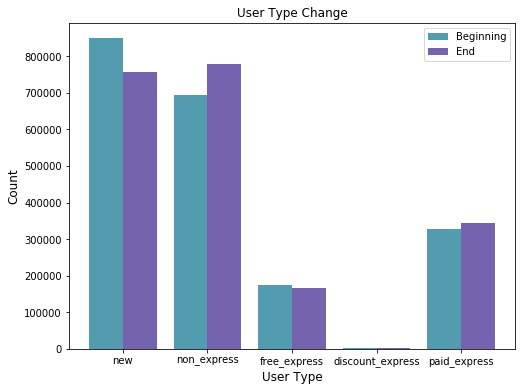

In [13]:
x = [1,2,3,4,5]
x1 = [a - 0.2 for a in x]
x2 = [a + 0.2 for a in x]
y1 = user_type_count.count_first.tolist()
y2 = user_type_count.count_last.tolist()
ind_width = 0.4

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x1, y1, align='center', color='#539caf',label='Beginning', width=ind_width)
ax.bar(x2, y2, align='center', color='#7663b0', label='End', width=ind_width)
ax.set_xlabel('User Type',fontsize=12)
ax.set_ylabel('Count',fontsize=12)
ax.set_title('User Type Change')
ax.legend(loc = 'upper right',fontsize=10)
ax.set_xticklabels(('', 'new','non_express','free_express','discount_express','paid_express'))
plt.savefig('20180903-20180930 User Type Changes.png')
plt.show()

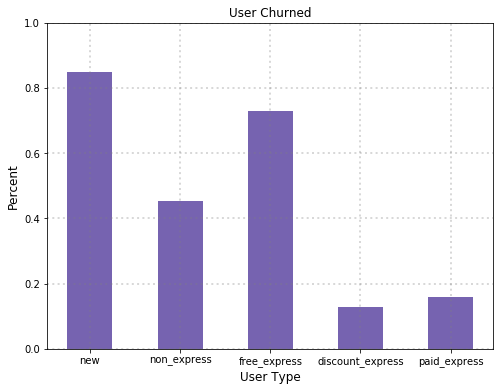

In [14]:
x = [1,2,3,4,5]
y1 = user_type_count.count_last.tolist()
t = label_df.merge(user_type_last, on=['user_id'], how='left')
y2 = t[t['label_visit'] != 0][['user_type',\
        'label_visit']].groupby('user_type').count().label_visit.tolist()

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x, [1 - i / float(j) for i, j in zip(y2, y1)], align='center',\
       color='#7663b0', width=0.5)
ax.set_xlabel('User Type',fontsize=12)
ax.set_ylabel('Percent',fontsize=12)
ax.set_ylim([0,1])
ax.set_title('User Churned')
ax.set_xticklabels(('', 'new','non_express','free_express','discount_express','paid_express'))
plt.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
plt.savefig('20180903-20180930 User Churned.png')
plt.show()

## User Orders Per Type

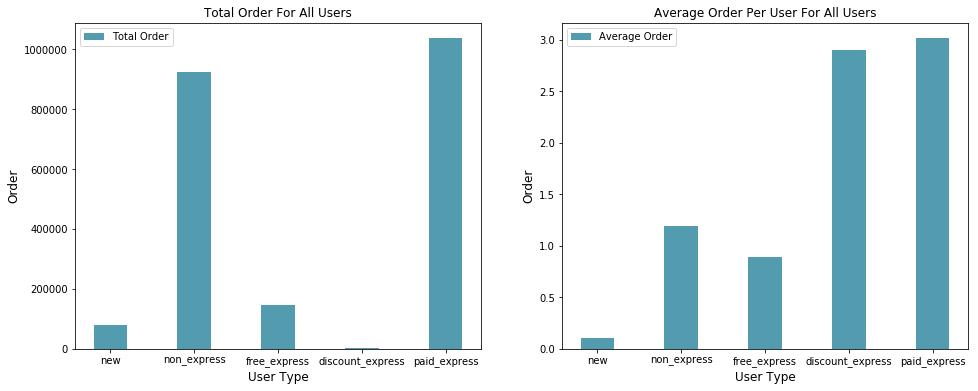

In [15]:
user_order_per_type = user_df[['user_type', 'order']].groupby(['user_type']).sum().reset_index()
user_order_per_type['user_type'] = user_order_per_type['user_type'].map(lambda x: user_type_map_reverse[x])

x = [1,2,3,4,5]
y1 = user_order_per_type.order.tolist()
ind_width = 0.4

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(121)
ax.bar(x, y1, align='center', color='#539caf',label='Total Order', width=ind_width)
ax.set_xlabel('User Type',fontsize=12)
ax.set_ylabel('Order',fontsize=12)
ax.set_title('Total Order For All Users')
ax.legend(loc = 'upper left',fontsize=10)
ax.set_xticklabels(('', 'new','non_express','free_express','discount_express','paid_express'))

y2 = [i/j for i, j in zip(user_order_per_type.order.tolist(), user_type_count.count_last.tolist())]
ax2 = fig.add_subplot(122)
ax2.bar(x, y2, align='center', color='#539caf',label='Average Order', width=ind_width)
ax2.set_xlabel('User Type',fontsize=12)
ax2.set_ylabel('Order',fontsize=12)
ax2.set_title('Average Order Per User For All Users')
ax2.legend(loc = 'upper left',fontsize=10)
ax2.set_xticklabels(('', 'new','non_express','free_express','discount_express','paid_express'))
plt.savefig('20180903-20180930 User Orders Per Type.png')
plt.show()

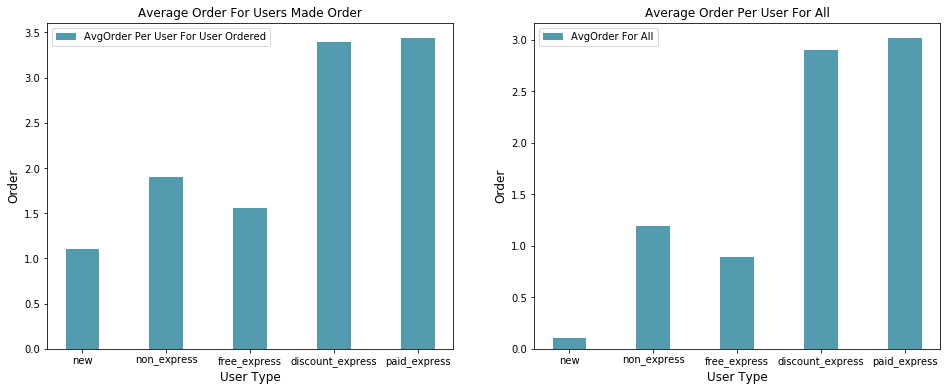

In [16]:
# Get the average number of orders for user type excluding the users who did not order during the period.

user_order_per_type_exclude = user_df[user_df['order'] > 0]\
    [['user_type', 'order']].groupby(['user_type']).sum().reset_index()
user_count_per_type_exclude = user_df[user_df['order'] > 0]\
    [['user_type', 'order']].groupby(['user_type']).count()\
    .reset_index().rename(columns={'order':'UserNum'})
user_per_type_exclude = user_order_per_type_exclude.merge(user_count_per_type_exclude, on='user_type')
user_per_type_exclude['AvgOrder'] = user_per_type_exclude['order'] / user_per_type_exclude['UserNum']

x = [1,2,3,4,5]
y1 = user_per_type_exclude['AvgOrder'].tolist()
ind_width = 0.4

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(121)
ax.bar(x, y1, align='center', color='#539caf',label='AvgOrder Per User For User Ordered', width=ind_width)
ax.set_xlabel('User Type',fontsize=12)
ax.set_ylabel('Order',fontsize=12)
ax.set_title('Average Order For Users Made Order')
ax.legend(loc = 'upper left',fontsize=10)
ax.set_xticklabels(('', 'new','non_express','free_express','discount_express','paid_express'))

y2 = [i/j for i, j in zip(user_order_per_type.order.tolist(), user_type_count.count_last.tolist())]
ax2 = fig.add_subplot(122)
ax2.bar(x, y2, align='center', color='#539caf',label='AvgOrder For All', width=ind_width)
ax2.set_xlabel('User Type',fontsize=12)
ax2.set_ylabel('Order',fontsize=12)
ax2.set_title('Average Order Per User For All')
ax2.legend(loc = 'upper left',fontsize=10)
ax2.set_xticklabels(('', 'new','non_express','free_express','discount_express','paid_express'))
plt.savefig('20180903-20180930 Average Orders For UserOrdered Per Type.png')
plt.show()

## User Lost Deliveries Per Type

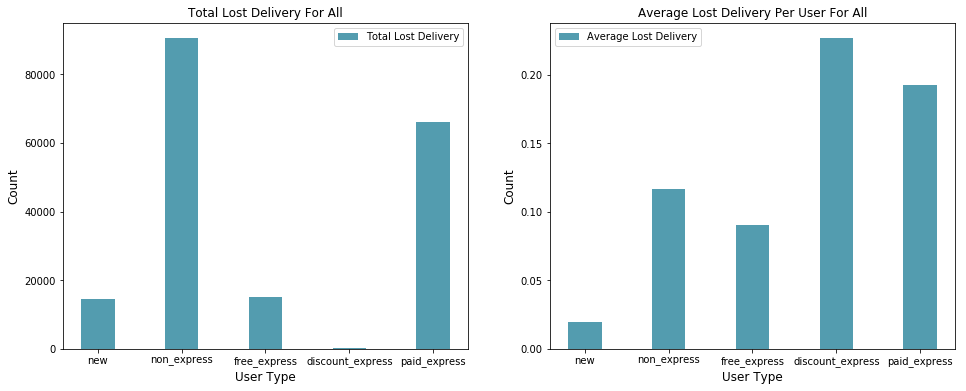

In [17]:
user_lost_per_type = user_df[['user_type', 'lost_estimate']].groupby(['user_type']).sum().reset_index()
user_lost_per_type['user_type'] = user_lost_per_type['user_type'].map(lambda x: user_type_map_reverse[x])

x = [1,2,3,4,5]
y1 = user_lost_per_type.lost_estimate.tolist()
ind_width = 0.4

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(121)
ax.bar(x, y1, align='center', color='#539caf',label='Total Lost Delivery', width=ind_width)
ax.set_xlabel('User Type',fontsize=12)
ax.set_ylabel('Count',fontsize=12)
ax.set_title('Total Lost Delivery For All')
ax.legend(loc = 'upper right',fontsize=10)
ax.set_xticklabels(('', 'new','non_express','free_express','discount_express','paid_express'))

y2 = [i/j for i, j in zip(user_lost_per_type.lost_estimate.tolist(), user_type_count.count_last.tolist())]
ax2 = fig.add_subplot(122)
ax2.bar(x, y2, align='center', color='#539caf',label='Average Lost Delivery', width=ind_width)
ax2.set_xlabel('User Type',fontsize=12)
ax2.set_ylabel('Count',fontsize=12)
ax2.set_title('Average Lost Delivery Per User For All')
ax2.legend(loc = 'upper left',fontsize=10)
ax2.set_xticklabels(('', 'new','non_express','free_express','discount_express','paid_express'))
plt.savefig('20180903-20180930 User Lost Deliveries Per Type.png')
plt.show()

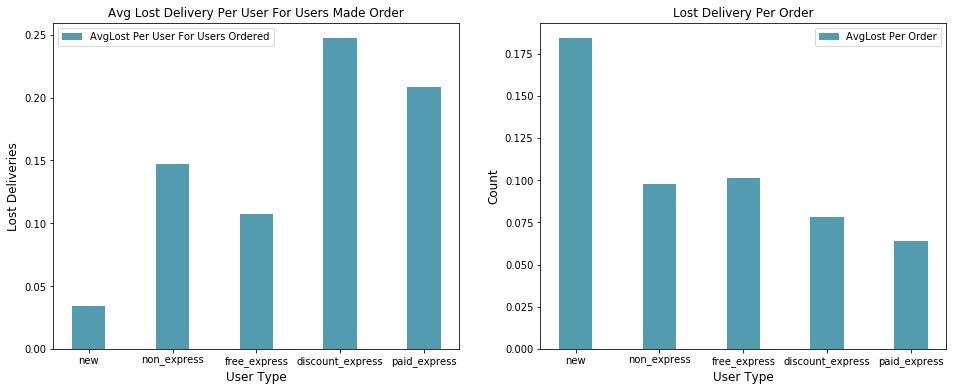

In [18]:
# Exclude users who did not make an order.
# Calculate the average lost deliveries per user for users who made order.
user_lost_per_type_exclude = user_df[user_df['order'] > 0]\
    [['user_type', 'lost_estimate']].groupby(['user_type']).sum().reset_index()
user_count_per_type_exclude = user_df[user_df['order'] > 0]\
    [['user_type', 'lost_estimate']].groupby(['user_type']).count()\
    .reset_index().rename(columns={'lost_estimate':'UserNum'})
user_per_type_exclude = user_lost_per_type_exclude.merge(user_count_per_type_exclude, on='user_type')
user_per_type_exclude['AvgLost'] = user_per_type_exclude['lost_estimate'] / user_per_type_exclude['UserNum']

x = [1,2,3,4,5]
y1 = user_per_type_exclude['AvgLost'].tolist()
y2 = [i/j for i,j in zip(user_lost_per_type.lost_estimate.tolist(), user_order_per_type.order.tolist())]
ind_width = 0.4

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(121)
ax.bar(x, y1, align='center', color='#539caf',label='AvgLost Per User For Users Ordered', width=ind_width)
ax.set_xlabel('User Type',fontsize=12)
ax.set_ylabel('Lost Deliveries',fontsize=12)
ax.set_title('Avg Lost Delivery Per User For Users Made Order')
ax.legend(loc = 'upper left',fontsize=10)
ax.set_xticklabels(('', 'new','non_express','free_express','discount_express','paid_express'))

ax2 = fig.add_subplot(122)
ax2.bar(x, y2, align='center', color='#539caf',label='AvgLost Per Order', width=ind_width)
ax2.set_xlabel('User Type',fontsize=12)
ax2.set_ylabel('Count',fontsize=12)
ax2.set_title('Lost Delivery Per Order')
ax2.legend(loc = 'upper right',fontsize=10)
ax2.set_xticklabels(('', 'new','non_express','free_express','discount_express','paid_express'))

plt.savefig('20180903-20180930 Lost Deliveries Per Order Per Type.png')
plt.show()

## User Visit Per Type

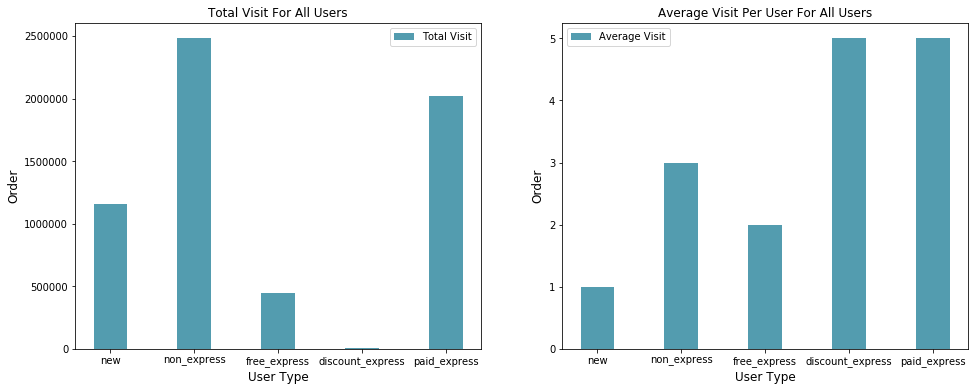

In [19]:
user_visit_per_type = user_df[['user_type', 'visit']].groupby(['user_type']).sum().reset_index()
user_visit_per_type['user_type'] = user_visit_per_type['user_type'].map(lambda x: user_type_map_reverse[x])

x = [1,2,3,4,5]
y1 = user_visit_per_type.visit.tolist()
ind_width = 0.4

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(121)
ax.bar(x, y1, align='center', color='#539caf',label='Total Visit', width=ind_width)
ax.set_xlabel('User Type',fontsize=12)
ax.set_ylabel('Order',fontsize=12)
ax.set_title('Total Visit For All Users')
#ax.set_ylim([0, 2850000])
ax.legend(loc = 'upper right',fontsize=10)
ax.set_xticklabels(('', 'new','non_express','free_express','discount_express','paid_express'))

y2 = [i/j for i, j in zip(user_visit_per_type.visit.tolist(), user_type_count.count_last.tolist())]
ax2 = fig.add_subplot(122)
ax2.bar(x, y2, align='center', color='#539caf',label='Average Visit', width=ind_width)
ax2.set_xlabel('User Type',fontsize=12)
ax2.set_ylabel('Order',fontsize=12)
ax2.set_title('Average Visit Per User For All Users')
ax2.legend(loc = 'upper left',fontsize=10)
ax2.set_xticklabels(('', 'new','non_express','free_express','discount_express','paid_express'))
plt.savefig('20180903-20180930 User Visits Per Type.png')
plt.show()

## About User Statistics Of Orders, Visits, Warehouse and Lost Deliveries

We don't need to consider new users in our model since new users almost all have one visit and 0 orders.

In [20]:
# What threshold to use to get good histogram.

k = 1
label = 'visit'
t_tot = float(len(user_df[user_df['user_type'] == k]))
t2 = user_df[(user_df['user_type'] == k) & (user_df[label] <= 11)][label]
count2, division2 = np.histogram(t2)
count2 = [round(i / t_tot, 3) * 100 for i in count2]
sum(count2)

99.80000000000004

In [21]:
user_stats = {}

for k in [1, 2, 3, 4, 5]:
    
    t_tot = float(len(user_df[user_df['user_type'] == k]))
    
    t1 = user_df[(user_df['user_type'] == k) & (user_df['lost_estimate'] <= 0.5)]['lost_estimate']
    count1, division1 = np.histogram(t1)
    count1 = [round(i / t_tot, 3) * 100 for i in count1]

    t2 = user_df[(user_df['user_type'] == k) & (user_df['order'] <= 10)]['order']
    count2, division2 = np.histogram(t2)
    count2 = [round(i / t_tot, 3) * 100 for i in count2]

    t3 = user_df[(user_df['user_type'] == k) & (user_df['visit'] <= 11)]['visit']
    count3, division3 = np.histogram(t3)
    count3 = [round(i / t_tot, 3) * 100 for i in count3]

    t4 = user_df[(user_df['user_type'] == k) & (user_df['warehouse_daily_avg'] <= 6)]['warehouse_daily_avg']
    count4, division4 = np.histogram(t4)
    count4 = [round(i / t_tot, 3) * 100 for i in count4]
    
    label_df_t = label_df.merge(user_type_last, on=['user_id'], how='left')
    t5 = label_df_t[(label_df_t['user_type'] == k) & (label_df_t['label_visit'] <= 10)]['label_visit']
    count5, division5 = np.histogram(t5)
    count5 = [round(i / t_tot, 3) * 100 for i in count5]

    user_stats[user_type_map_reverse[k]] =pd.DataFrame({'Order': division2[:-1],
                                                        'OPct': count2,
                                                        'Visit': division3[:-1],
                                                        'VPct': count3,
                                                        'Lost': division1[:-1],
                                                        'LPct': count1,
                                                        'Warehouse': division4[:-1],
                                                        'WPct': count4,
                                                         'Label_Visit': division5[:-1],
                                                        'LVPct': count5})
    user_stats[k] = user_stats[user_type_map_reverse[k]][['Order',\
                                           'OPct', 'Visit', 'VPct',\
                                           'Lost', 'LPct', \
                                            'Label_Visit', 'LVPct']]
    
    print('\nFor %s:'%(user_type_map_reverse[k]))
    print(user_stats[k])


For new:
   Order  OPct  Visit  VPct      Lost  LPct  Label_Visit  LVPct
0    0.0  90.5    1.0  73.7  0.000000  89.9          0.0   84.8
1    1.0   8.9    2.0  15.4  0.049993   3.6          1.0    8.8
2    2.0   0.4    3.0   5.4  0.099986   2.4          2.0    3.0
3    3.0   0.1    4.0   2.4  0.149979   2.0          3.0    1.4
4    4.0   0.0    5.0   1.2  0.199972   1.1          4.0    0.7
5    5.0   0.0    6.0   0.7  0.249965   0.4          5.0    0.4
6    6.0   0.0    7.0   0.4  0.299958   0.2          6.0    0.3
7    7.0   0.0    8.0   0.2  0.349950   0.1          7.0    0.2
8    8.0   0.0    9.0   0.2  0.399943   0.1          8.0    0.1
9    9.0   0.0   10.0   0.2  0.449936   0.1          9.0    0.1

For non_express:
   Order  OPct  Visit  VPct      Lost  LPct  Label_Visit  LVPct
0    0.0  37.4    1.0  31.6  0.000000  51.9          0.0   45.2
1    1.0  33.3    2.0  22.6  0.050000  13.9          1.0   18.4
2    2.0  15.4    3.0  14.7  0.099999   8.1          2.0   11.7
3    3.0   7

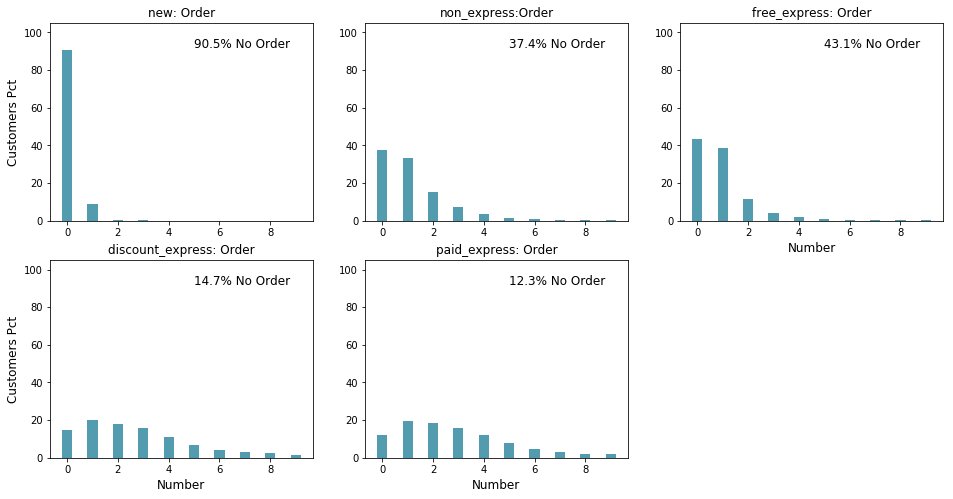

In [22]:
png_name = 'Customer Order Number'
label = 'Order'
label_pct = 'OPct'

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(231)
ax1.bar(user_stats[1][label], user_stats[1][label_pct], align='center', color='#539caf', width=ind_width)
ax1.set_ylabel('Customers Pct',fontsize=12)
ax1.text(5, 92, '90.5% No Order', fontsize=12, color='black')
ax1.set_title('new: ' + label)
ax1.set_ylim([0, 105])
#ax1.legend(loc = 'upper right',fontsize=10)

ax2 = fig.add_subplot(232)
ax2.bar(user_stats[2][label], user_stats[2][label_pct], align='center', color='#539caf', width=ind_width)
ax2.set_title('non_express:' + label)
ax2.text(5, 92, '37.4% No Order', fontsize=12, color='black')
ax2.set_ylim([0, 105])
#ax2.legend(loc = 'upper right',fontsize=10)

ax3 = fig.add_subplot(233)
ax3.bar(user_stats[3][label], user_stats[3][label_pct], align='center', color='#539caf', width=ind_width)
ax3.set_title('free_express: ' + label)
ax3.set_xlabel('Number',fontsize=12)
ax3.text(5, 92, '43.1% No Order', fontsize=12, color='black')
ax3.set_ylim([0, 105])
#ax3.legend(loc = 'upper right',fontsize=10)

ax4 = fig.add_subplot(234)
ax4.bar(user_stats[4][label], user_stats[4][label_pct], align='center', color='#539caf', width=ind_width)
ax4.set_xlabel('Number',fontsize=12)
ax4.set_ylabel('Customers Pct',fontsize=12)
ax4.text(5, 92, '14.7% No Order', fontsize=12, color='black')
ax4.set_title('discount_express: ' + label)
ax4.set_ylim([0, 105])
#ax4.legend(loc = 'upper right',fontsize=10)

ax5 = fig.add_subplot(235)
ax5.bar(user_stats[5][label], user_stats[5][label_pct], align='center', color='#539caf', width=ind_width)
ax5.set_xlabel('Number',fontsize=12)
ax5.set_title('paid_express: ' + label)
ax5.text(5, 92, '12.3% No Order', fontsize=12, color='black')
ax5.set_ylim([0, 105])
#ax5.legend(loc = 'upper right',fontsize=10)

plt.savefig('20180903-20180930 ' + png_name + ' Distribution.png')
plt.show()

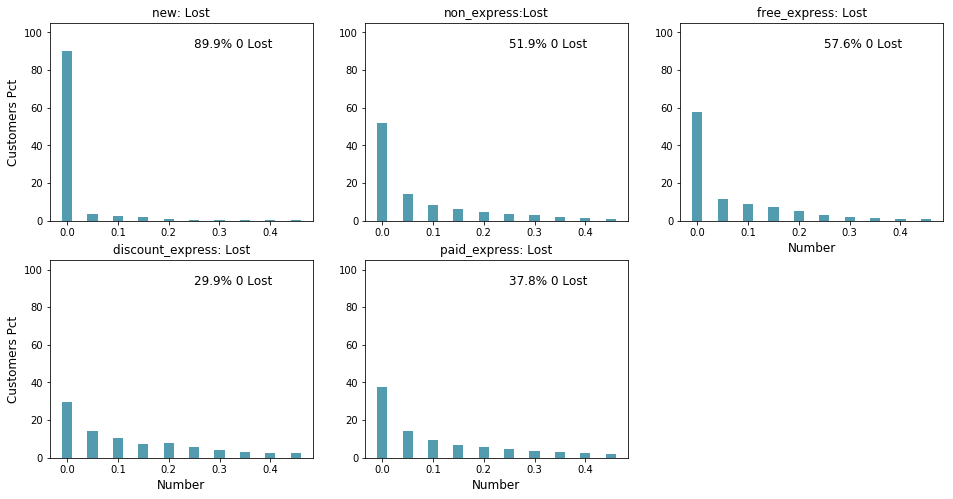

In [23]:
# For Lost
label = 'Lost'
label_pct = 'LPct'
png_name = 'Customer Lost Delivery Number'

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(231)
ax1.bar(user_stats[1][label], user_stats[1][label_pct], align='center', color='#539caf', width=0.02)
ax1.set_ylabel('Customers Pct',fontsize=12)
ax1.text(0.25, 92, '89.9% 0 Lost', fontsize=12, color='black')
ax1.set_title('new: ' + label)
#ax1.set_xlim([0,0.5])
ax1.set_ylim([0, 105])
#ax1.legend(loc = 'upper right',fontsize=10)

ax2 = fig.add_subplot(232)
ax2.bar(user_stats[2][label], user_stats[2][label_pct], align='center', color='#539caf', width=0.02)
ax2.set_title('non_express:' + label)
ax2.text(0.25, 92, '51.9% 0 Lost', fontsize=12, color='black')
#ax2.set_xlim([0,0.5])
ax2.set_ylim([0, 105])
#ax2.legend(loc = 'upper right',fontsize=10)

ax3 = fig.add_subplot(233)
ax3.bar(user_stats[3][label], user_stats[3][label_pct], align='center', color='#539caf', width=0.02)
ax3.set_title('free_express: ' + label)
ax3.set_xlabel('Number',fontsize=12)
ax3.text(0.25, 92, '57.6% 0 Lost', fontsize=12, color='black')
#ax3.set_xlim([0,0.5])
ax3.set_ylim([0, 105])
#ax3.legend(loc = 'upper right',fontsize=10)

ax4 = fig.add_subplot(234)
ax4.bar(user_stats[4][label], user_stats[4][label_pct], align='center', color='#539caf', width=0.02)
ax4.set_xlabel('Number',fontsize=12)
ax4.set_ylabel('Customers Pct',fontsize=12)
ax4.set_title('discount_express: ' + label)
ax4.text(0.25, 92, '29.9% 0 Lost', fontsize=12, color='black')
#ax4.set_xlim([0,0.5])
ax4.set_ylim([0, 105])
#ax4.legend(loc = 'upper right',fontsize=10)

ax5 = fig.add_subplot(235)
ax5.bar(user_stats[5][label], user_stats[5][label_pct], align='center', color='#539caf', width=0.02)
ax5.set_xlabel('Number',fontsize=12)
ax5.set_title('paid_express: ' + label)
ax5.text(0.25, 92, '37.8% 0 Lost', fontsize=12, color='black')
#ax5.set_xlim([0,0.5])
ax5.set_ylim([0, 105])
#ax5.legend(loc = 'upper right',fontsize=10)

plt.savefig('20180903-20180930 ' + png_name + ' Distribution.png')
plt.show()

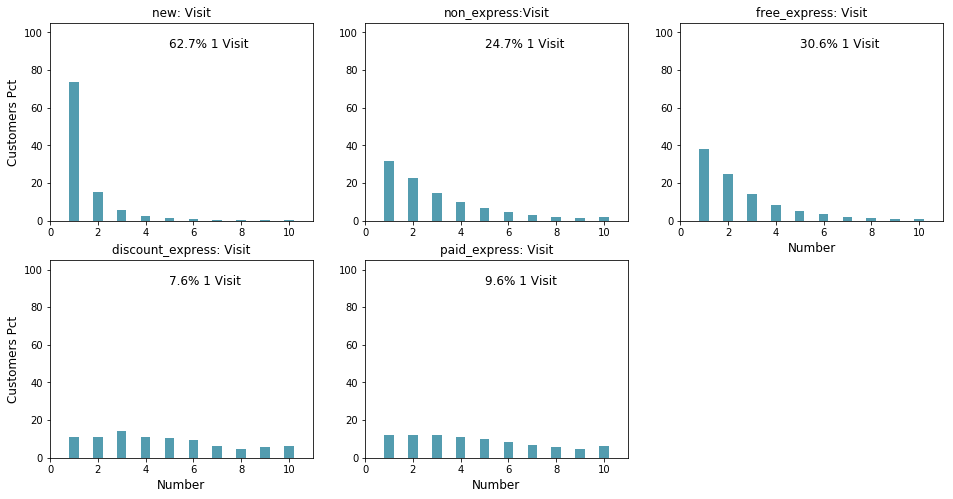

In [24]:
# For Visit
label = 'Visit'
label_pct = 'VPct'
png_name = 'Customer Visit'

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(231)
ax1.bar(user_stats[1][label], user_stats[1][label_pct], align='center', color='#539caf', width=0.4)
ax1.set_ylabel('Customers Pct',fontsize=12)
ax1.text(5, 92, '62.7% 1 Visit', fontsize=12, color='black')
ax1.set_title('new: ' + label)
ax1.set_xlim([0,11])
ax1.set_ylim([0, 105])
#ax1.legend(loc = 'upper right',fontsize=10)

ax2 = fig.add_subplot(232)
ax2.bar(user_stats[2][label], user_stats[2][label_pct], align='center', color='#539caf', width=0.4)
ax2.set_title('non_express:' + label)
ax2.text(5, 92, '24.7% 1 Visit', fontsize=12, color='black')
ax2.set_xlim([0,11])
ax2.set_ylim([0, 105])
#ax2.legend(loc = 'upper right',fontsize=10)

ax3 = fig.add_subplot(233)
ax3.bar(user_stats[3][label], user_stats[3][label_pct], align='center', color='#539caf', width=0.4)
ax3.set_title('free_express: ' + label)
ax3.set_xlabel('Number',fontsize=12)
ax3.text(5, 92, '30.6% 1 Visit', fontsize=12, color='black')
ax3.set_xlim([0,11])
ax3.set_ylim([0, 105])
#ax3.legend(loc = 'upper right',fontsize=10)

ax4 = fig.add_subplot(234)
ax4.bar(user_stats[4][label], user_stats[4][label_pct], align='center', color='#539caf', width=0.4)
ax4.set_xlabel('Number',fontsize=12)
ax4.set_ylabel('Customers Pct',fontsize=12)
ax4.set_title('discount_express: ' + label)
ax4.text(5, 92, '7.6% 1 Visit', fontsize=12, color='black')
ax4.set_xlim([0,11])
ax4.set_ylim([0, 105])
#ax4.legend(loc = 'upper right',fontsize=10)

ax5 = fig.add_subplot(235)
ax5.bar(user_stats[5][label], user_stats[5][label_pct], align='center', color='#539caf', width=0.4)
ax5.set_xlabel('Number',fontsize=12)
ax5.set_title('paid_express: ' + label)
ax5.text(5, 92, '9.6% 1 Visit', fontsize=12, color='black')
ax5.set_xlim([0,11])
ax5.set_ylim([0, 105])
#ax5.legend(loc = 'upper right',fontsize=10)

plt.savefig('20180903-20180930 ' + png_name + ' Distribution.png')
plt.show()

## Correlation Relationship

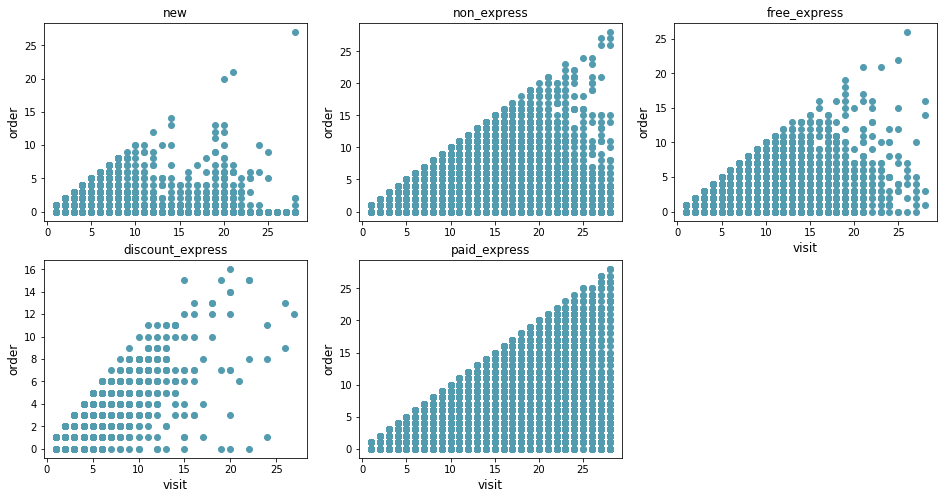

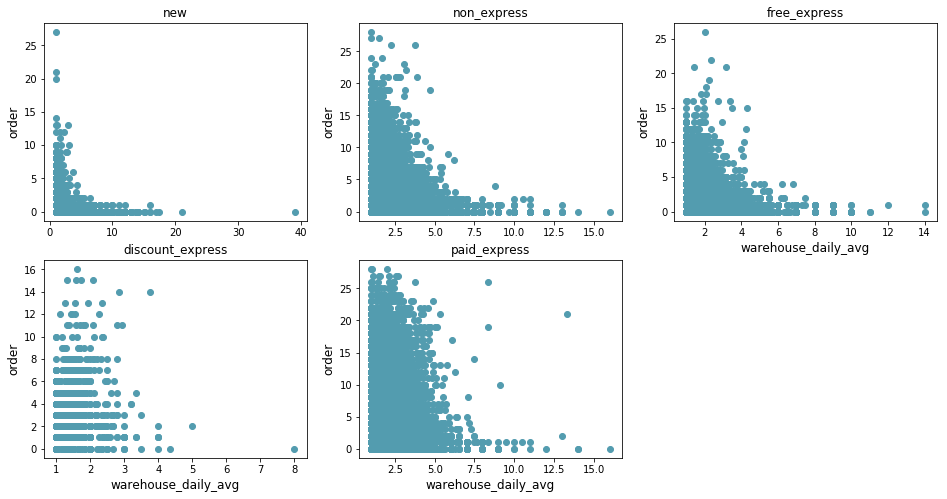

In [25]:
x_label_list = ['visit', 'warehouse_daily_avg']
y_label_list = ['order', 'order']

for x_label, y_label in zip(x_label_list, y_label_list):
    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(231)
    ax1.scatter(user_df[user_df['user_type'] == 1][x_label],\
                user_df[user_df['user_type'] == 1][y_label], color='#539caf')
    ax1.set_ylabel(y_label,fontsize=12)
    #ax1.set_ylim([0, 10])
    ax1.set_title(user_type_map_reverse[1])
    #ax1.legend(loc = 'upper right',fontsize=10)

    ax2 = fig.add_subplot(232)
    ax2.scatter(user_df[user_df['user_type'] == 2][x_label],\
                user_df[user_df['user_type'] == 2][y_label], color='#539caf')
    ax2.set_ylabel(y_label,fontsize=12)
    #ax2.set_ylim([0, 10])
    ax2.set_title(user_type_map_reverse[2])
    #ax2.legend(loc = 'upper right',fontsize=10)

    ax3 = fig.add_subplot(233)
    ax3.scatter(user_df[user_df['user_type'] == 3][x_label],\
                user_df[user_df['user_type'] == 3][y_label], color='#539caf')
    ax3.set_ylabel(y_label,fontsize=12)
    ax3.set_xlabel(x_label,fontsize=12)
    #ax3.set_ylim([0, 10])
    ax3.set_title(user_type_map_reverse[3])
    #ax3.legend(loc = 'upper right',fontsize=10)

    ax4 = fig.add_subplot(234)
    ax4.scatter(user_df[user_df['user_type'] == 4][x_label],\
                user_df[user_df['user_type'] == 4][y_label], color='#539caf')
    ax4.set_ylabel(y_label,fontsize=12)
    ax4.set_xlabel(x_label,fontsize=12)
    #ax4.set_ylim([0, 10])
    ax4.set_title(user_type_map_reverse[4])
    #ax4.legend(loc = 'upper right',fontsize=10)

    ax5 = fig.add_subplot(235)
    ax5.scatter(user_df[user_df['user_type'] == 5][x_label],\
                user_df[user_df['user_type'] == 5][y_label], color='#539caf')
    ax5.set_ylabel(y_label,fontsize=12)
    ax5.set_xlabel(x_label,fontsize=12)
    #ax5.set_ylim([0, 10])
    ax5.set_title(user_type_map_reverse[5])
    #ax5.legend(loc = 'upper right',fontsize=10)

    plt.savefig('20180903-20180930 ' + y_label + ' vs ' + x_label + ' .png')
    plt.show()

## Any Signal From Lost Deliveries With Visits/Orders

In [26]:
df_explore = user_df.merge(label_df, on=['user_id'], how='left')

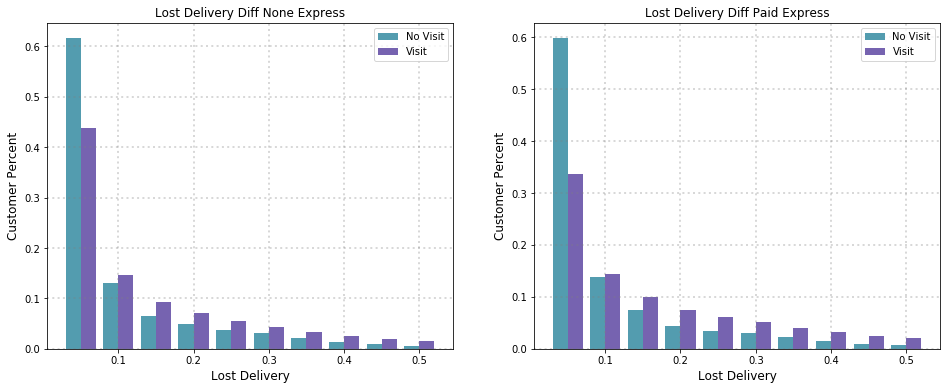

In [27]:
ind_width = 0.02

x = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
x1 = [a - 0.01 for a in x]
x2 = [a + 0.01 for a in x]

t_type1 = 2
y1, division1 = np.histogram(df_explore[(df_explore['label_visit'] == 0)\
           & (df_explore['user_type'] == t_type1)\
           & (df_explore['lost_estimate'] <= 0.5)]['lost_estimate'])
t_num_visit1 = len(df_explore[(df_explore['label_visit'] == 0)\
           & (df_explore['user_type'] == t_type1)])
y1 = [i / float(t_num_visit1) for i in y1]

y2, division1 = np.histogram(df_explore[(df_explore['label_visit'] != 0)\
           & (df_explore['user_type'] == t_type1)\
           & (df_explore['lost_estimate'] <= 0.5)]['lost_estimate'])
t_num_visit2 = len(df_explore[(df_explore['label_visit'] != 0)\
           & (df_explore['user_type'] == t_type1)])
y2 = [i / float(t_num_visit2) for i in y2]

fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(121)
ax1.bar(x1, y1, align='center', color='#539caf',label='No Visit', width=ind_width)
ax1.bar(x2, y2, align='center', color='#7663b0', label='Visit', width=ind_width)
#ax1.plot(x1, y1, color='#539caf')
#ax1.plot(x1, y2, color='#7663b0')
ax1.set_xlabel('Lost Delivery',fontsize=12)
ax1.set_ylabel('Customer Percent',fontsize=12)
ax1.set_title('Lost Delivery Diff None Express')
ax1.legend(loc = 'upper right',fontsize=10)
ax1.set_xticklabels(('', '0.1', '0.2', '0.3', '0.4', '0.5'))
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

t_type2 = 5
y3, division1 = np.histogram(df_explore[(df_explore['label_visit'] == 0)\
           & (df_explore['user_type'] == t_type2)\
           & (df_explore['lost_estimate'] <= 0.5)]['lost_estimate'])
t_num_visit3 = len(df_explore[(df_explore['label_visit'] == 0)\
           & (df_explore['user_type'] == t_type2)])
y3 = [i / float(t_num_visit3) for i in y3]

y4, division1 = np.histogram(df_explore[(df_explore['label_visit'] != 0)\
           & (df_explore['user_type'] == t_type2)\
           & (df_explore['lost_estimate'] <= 0.5)]['lost_estimate'])
t_num_visit4 = len(df_explore[(df_explore['label_visit'] != 0)\
           & (df_explore['user_type'] == t_type2)])
y4 = [i / float(t_num_visit4) for i in y4]

ax2 = fig.add_subplot(122)
ax2.bar(x1, y3, align='center', color='#539caf',label='No Visit', width=ind_width)
ax2.bar(x2, y4, align='center', color='#7663b0', label='Visit', width=ind_width)
#ax2.plot(x1, y3, color='#539caf')
#ax2.plot(x1, y4, color='#7663b0')
ax2.set_xlabel('Lost Delivery',fontsize=12)
ax2.set_ylabel('Customer Percent',fontsize=12)
ax2.set_title('Lost Delivery Diff Paid Express')
ax2.legend(loc = 'upper right',fontsize=10)
ax2.set_xticklabels(('', '0.1', '0.2', '0.3', '0.4', '0.5'))
ax2.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

plt.savefig('20180903-20180930 Lost Deliveries Diff.png')
plt.show()

In [28]:
# sm.OLS() Can Fit Negative Line?

for u_type in [5]:
    
    train_X = df_explore[df_explore['user_type'] == u_type]['lost_estimate']
    train_y = df_explore[df_explore['user_type'] == u_type]['label_visit']
    X2 = sm.add_constant(train_X)
    est = sm.OLS(train_y, X2)
    est2 = est.fit()
    print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:            label_visit   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                 5.608e+04
Date:                Tue, 05 Feb 2019   Prob (F-statistic):               0.00
Time:                        16:33:07   Log-Likelihood:            -9.8815e+05
No. Observations:              344016   AIC:                         1.976e+06
Df Residuals:                  344014   BIC:                         1.976e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.6779      0.009    423.254

## Feature Engineering For User Infos

In [29]:
def get_email_type(x):
    
    m = re.search(r'(\S+)@(\S+)', x)
    
    return m.group(2)

user_infos['email_type'] = user_infos['email'].map(lambda x: get_email_type(x))
user_infos['has_phone'] = user_infos['phone'].notnull().map(lambda x: 1 if x else 0)

user_infos.rename(columns={'id':'user_id'}, inplace=True)
user_infos = user_infos.merge(user_ids, on=['user_id'])
user_infos['life_days'] = user_infos[['created_at', 'last_date']]\
    .apply(lambda x: (x[1] - x[0]).days, axis=1)

user_info_df = user_infos[['user_id', 'has_phone', 'gender',\
                           'receive_emails', 'life_days']].copy()

In [30]:
user_infos.head(3)

,user_id,name,email,phone,became_express_member_on,sign_in_count,active,gender,receive_emails,household_income,...,converted_to_id,first_name,last_name,created_at,email_type,has_phone,first_date,last_date,label_date,life_days
0,35322,Meredith Zappert,meredith.story@gmail.com,4109910716,NaT,74,True,female,True,None,...,None,Meredith,Zappert,2013-07-03 19:25:09.000000,gmail.com,1,2018-09-04,2018-10-02,2018-10-30,1916
1,38936,Yi,zhengyi8341@gmail.com,6503538692,NaT,10,True,male,False,None,...,None,Yi,None,2013-07-24 03:12:22.000000,gmail.com,1,2018-09-16,2018-10-14,2018-11-11,1907
2,71321,None,jentosic@sbcglobal.net,7734809198,NaT,5,True,None,True,None,...,None,Jen,Kudesh,2013-12-06 01:15:12.625791,sbcglobal.net,1,2018-09-04,2018-10-02,2018-10-30,1760


In [31]:
user_infos.isnull().sum()

user_id                           0
name                        1427542
email                             0
phone                        612482
became_express_member_on    2046006
sign_in_count                     0
active                            0
gender                      1885066
receive_emails                    0
household_income            2045741
occupation                  2046059
vip                               0
orders_count                      0
twilio_number_id             795699
fraud_kind                  1544687
phone_type                  2024785
phone_provider              2039727
deleted_ind                       0
converted_from_id           2046082
converted_to_id             2043533
first_name                        0
last_name                    154761
created_at                        0
email_type                        0
has_phone                         0
first_date                        0
last_date                         0
label_date                  

## Feature Engineering: Interaction Feature

In [32]:
user_df['lost_x_visit'] = user_df['lost_estimate'] * user_df['visit']

## Model Train

Features considered: 'lost_estimate', 'visit', 'has_phone', 'life_days', 'gender_male', 'gender_female', 'warehouse_daily_avg', 'receive_emails', 'life_days'

In [33]:
df = user_df.merge(user_info_df, on=['user_id'])
df = df.merge(label_df, on=['user_id'])
df['gender'] = df['gender'].map(lambda x: 'male' if x == 'male (hidden)'\
                                else 'female' if x == 'female (hidden)' else x)
df = df.join(pd.get_dummies(df.gender, prefix='gender'))
df['receive_emails'] = df['receive_emails'].map(lambda x: 1 if x else 0)
df.rename(columns={"gender_female (hidden)":"gender_female_hidden",\
                   "gender_male (hidden)":"gender_male_hidden"}, inplace=True)

In [34]:
df.columns

Index([            u'user_id',       u'lost_estimate',               u'order',
                     u'visit', u'warehouse_daily_avg',      u'visit_interval',
             u'num_warehouse',           u'user_type',        u'lost_x_visit',
                 u'has_phone',              u'gender',      u'receive_emails',
                 u'life_days',         u'label_visit',         u'label_order',
             u'gender_female',         u'gender_male'],
      dtype='object')

In [35]:
df.head(3)

,user_id,lost_estimate,order,visit,warehouse_daily_avg,visit_interval,num_warehouse,user_type,lost_x_visit,has_phone,gender,receive_emails,life_days,label_visit,label_order,gender_female,gender_male
0,11,0.060055,1.0,1,1.000000,28.000000,1,2,0.060055,1,male,1,2319,0.0,0.0,0,1
1,22,0.209654,1.0,6,3.333333,8.666667,13,3,1.257927,1,male,1,2317,5.0,0.0,0,1
2,52,0.000000,0.0,1,1.000000,28.000000,1,2,0.000000,1,male,0,2292,2.0,0.0,0,1


## Explore Correlation Between Features

  - For Non-express:
    - lost = 2.38 + 6.96 * visit, R^2 = 0.22
    - lost = 0.86 + 2.86 * order, R^2 = 0.14
    - lost = 20.2 - 16.9 * visit_interval, R^2 = 0.15
    - lost = 1.40 + 2.11 * num_warehouse, R^2 = 0.10
    - lost = 1.22 + 0.49 * warehouse_daily_avg, R^2 = 0.03
    
    
  - For Paid-express:
    - lost = 4.47 + 7.24 * visit, R^2 = 0.23
    - lost = 2.37 + 3.32 * order, R^2 = 0.14
    - lost = 14.5 - 9.90 * visit_interval, R^2 = 0.14
    - lost = 1.75 + 2.67 * num_warehouse, R^2 = 0.19
    - lost = 1.26 + 0.54 * warehouse_daily_avg, R^2 = 0.09

In [36]:
t_type = 2
corr_X = df[df['user_type'] == t_type]['lost_estimate']
corr_y = df[df['user_type'] == t_type]['warehouse_daily_avg']

X1 = sm.add_constant(corr_X)
est = sm.OLS(corr_y, X1)
est2 = est.fit()
print(est2.summary())

                             OLS Regression Results                            
Dep. Variable:     warehouse_daily_avg   R-squared:                       0.025
Model:                             OLS   Adj. R-squared:                  0.025
Method:                  Least Squares   F-statistic:                 2.018e+04
Date:                 Tue, 05 Feb 2019   Prob (F-statistic):               0.00
Time:                         16:34:57   Log-Likelihood:            -6.4414e+05
No. Observations:               777617   AIC:                         1.288e+06
Df Residuals:                   777615   BIC:                         1.288e+06
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.2221      0.001 

## Classification

### Churn Logistic Regression

In [37]:
from sklearn.linear_model import LogisticRegressionCV

# Get train, test and predict DataFrame
user_type_model = 5

data = df[df['user_type'] == user_type_model].copy().reset_index().drop(['index'], axis=1)

data['label_visit'] = data['label_visit'].map(lambda x: 0 if x == 0 else 1)

clf_features = ['lost_estimate', 'visit', 'order',\
                'visit_interval', 'num_warehouse',\
                'warehouse_daily_avg',\
                'has_phone', 'gender_male',\
                'gender_female']

data_Y = np.array(data['label_visit'])
# Normalize Features
t_data = data[clf_features].copy()
normalized_data = (t_data - t_data.mean()) / t_data.std()
data_X = np.array(normalized_data)

sss = StratifiedShuffleSplit(data_Y, 1, test_size=0.1, random_state=0)
for train_index, test_index in sss:
    train_X, test_X = data_X[train_index], data_X[test_index]
    train_y, test_y = data_Y[train_index], data_Y[test_index]

clf = LogisticRegressionCV(cv=5).fit(train_X, train_y)
print("%.3f"%(clf.score(test_X, test_y)))

0.858


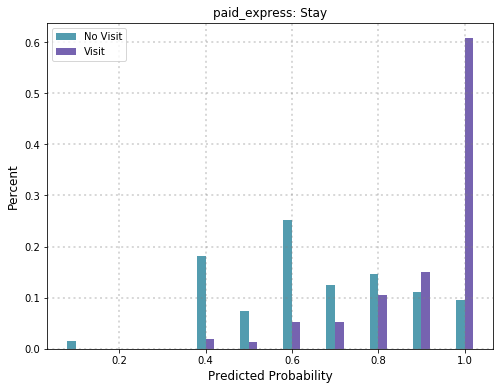

In [38]:
predict_y = clf.predict_proba(test_X)
metric_df = pd.DataFrame({'predict':predict_y[:,1], 'label_visit':test_y})

ind_width = 0.02

x = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
x1 = [a - 0.01 for a in x]
x2 = [a + 0.01 for a in x]

y1, division1 = np.histogram(metric_df[(metric_df['label_visit'] == 0)]\
                             ['predict'])
t_num_visit1 = len(metric_df[(metric_df['label_visit'] == 0)])
y1 = [i / float(t_num_visit1) for i in y1]

y2, division2 = np.histogram(metric_df[(metric_df['label_visit'] == 1)]\
                             ['predict'])
t_num_visit2 = len(metric_df[(metric_df['label_visit'] == 1)])
y2 = [i / float(t_num_visit2) for i in y2]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x1, y1, align='center', color='#539caf',label='No Visit', width=ind_width)
ax1.bar(x2, y2, align='center', color='#7663b0', label='Visit', width=ind_width)
ax1.set_xlabel('Predicted Probability',fontsize=12)
ax1.set_ylabel('Percent',fontsize=12)
ax1.set_title(user_type_map_reverse[user_type_model] + ': Stay')
ax1.legend(loc = 'upper left',fontsize=10)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
#ax1.set_xticklabels(('', '0.1', '0.2', '0.3', '0.4', '0.5'))
plt.savefig('20180903-20180930 LR Churn Prediction' + user_type_map_reverse[user_type_model] + '.png')
plt.show()

## Regression

### User Linear Regression

In [39]:
# Get train, test and predict DataFrame
model_type = 'elasticnet' # 'ridge', 'lasso', 'elasticnet'
user_type_model = 5 

clf_features = ['lost_estimate', 'visit', 'order',\
                'visit_interval', 'num_warehouse',\
                'warehouse_daily_avg',\
                'has_phone', 'gender_male',\
                'gender_female']

data = df[df['user_type'] == user_type_model].copy().reset_index().drop(['index'], axis=1)
data_Y = data['label_visit'].copy()

# Normalize Features
t_data = data[clf_features].copy()
data_X = (t_data - t_data.mean()) / t_data.std()

train_X, test_X, train_y, test_y = train_test_split(data_X, data_Y, test_size=.1)

alpha_list = [0.0001, 0.0003, 0.0006, 0.001, 0.003,\
              0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1]
if model_type == "ridge":
    clf = linear_model.RidgeCV(alphas = alpha_list, cv = 10)
elif model_type == "lasso":
    clf = linear_model.LassoCV(alphas = alpha_list, max_iter = 5000, cv = 10)
elif model_type == "elasticnet":
    clf = linear_model.ElasticNetCV(l1_ratio = [.1, .5, .7, .9, .95, .99, 1],\
                                     alphas = alpha_list,\
                                     max_iter = 1000, cv = 3)

clf.fit(train_X, train_y)
predict_y = clf.predict(test_X)

compare_df = pd.DataFrame({'order':test_y, 'predict':predict_y})

if False:
    fig, ax = plt.subplots(figsize=(8,6))
    ax.scatter(compare_df['order'], compare_df['predict'], color='#539caf')
    ax.set_xlabel('Order',fontsize=12)
    ax.set_ylabel('Predict',fontsize=12)
    ax.set_title('%s Result'%(model_type))
    plt.savefig('20180903-20180930 LassoCV Result.png')
    plt.show()

/Users/jianhuitian/.virtualenvs/staffing/lib/python2.7/site-packages/sklearn/linear_model/base.py:424: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if precompute == 'auto':


In [40]:
print('Regularization %.2f.\n'%(clf.alpha_))
coef_dict = {}
for coef, feat in zip(clf.coef_, clf_features):
    coef_dict[feat] = round(coef, 3)

print('%s %s:\n'%(model_type, user_type_map_reverse[user_type_model]))
print(coef_dict)

Regularization 0.00.

elasticnet paid_express:

{'visit_interval': 0.31, 'visit': 3.338, 'warehouse_daily_avg': 0.214, 'lost_estimate': -0.048, 'gender_female': 0.022, 'num_warehouse': -0.084, 'gender_male': -0.019, 'has_phone': 0.05, 'order': 0.653}


#### Estimate Lost Demand Impact

Get deltaOrder for 0.1, 0.2, 0.3, 0.4, 0.5 deltaLD.

In [41]:
deltaLD_d = []
t_std = t_data['lost_estimate'].std()
delta_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
for deltaLD in delta_list:
    
    # Add deltaLD   
    t = []
    for i in range(len(test_X)):
        t.append([deltaLD / t_std, 0, 0, 0, 0, 0, 0, 0, 0])
    X2 = np.add(test_X, np.array(t))

    t_predict = clf.predict(X2)
    print(X2[['lost_estimate', 'visit']].head(1))
    deltaLD_d.append((deltaLD, round(np.mean(test_y), 2),\
                      round(np.mean(t_predict), 2)))
                     
print("deltaLD , order_mean, predicted_mean")
for i in range(len(deltaLD_d)):
    print(deltaLD_d[i])

        lost_estimate     visit
136435       1.241065 -0.420186
        lost_estimate     visit
136435       1.578004 -0.420186
        lost_estimate     visit
136435       1.914943 -0.420186
        lost_estimate     visit
136435       2.251882 -0.420186
        lost_estimate     visit
136435       2.588821 -0.420186
        lost_estimate     visit
136435        2.92576 -0.420186
deltaLD , order_mean, predicted_mean
(0, 4.82, 4.79)
(0.1, 4.82, 4.77)
(0.2, 4.82, 4.76)
(0.3, 4.82, 4.74)
(0.4, 4.82, 4.72)
(0.5, 4.82, 4.71)


### Use statsmodel

In [42]:
# Use the same train_X and test_X as Lasso.

X2 = sm.add_constant(train_X)
est = sm.OLS(train_y, X2)
est2 = est.fit()
print(clf_features)
print(est2.summary())

['lost_estimate', 'visit', 'order', 'visit_interval', 'num_warehouse', 'warehouse_daily_avg', 'has_phone', 'gender_male', 'gender_female']
                            OLS Regression Results                            
Dep. Variable:            label_visit   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                 5.308e+04
Date:                Tue, 05 Feb 2019   Prob (F-statistic):               0.00
Time:                        16:35:11   Log-Likelihood:            -7.6818e+05
No. Observations:              309614   AIC:                         1.536e+06
Df Residuals:                  309604   BIC:                         1.536e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0

#### Estimate Lost Demand Impact

In [43]:
deltaLD_d = []
t_std = t_data['lost_estimate'].std()
delta_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
for deltaLD in delta_list:
    
    # Add deltaLD   
    t = []
    for i in range(len(test_X)):
        t.append([deltaLD / t_std, 0, 0, 0, 0, 0, 0, 0, 0])
    X2 = np.add(test_X, np.array(t))

    X2 = sm.add_constant(X2)
    t_predict = est2.predict(X2)
    print(X2[['lost_estimate', 'visit']].head(1))
    deltaLD_d.append((deltaLD, round(np.mean(test_y), 2),\
                      round(np.mean(t_predict), 2)))
                     
print("deltaLD , order_mean, predicted_mean")
for i in range(len(deltaLD_d)):
    print(deltaLD_d[i])

        lost_estimate     visit
136435       1.241065 -0.420186
        lost_estimate     visit
136435       1.578004 -0.420186
        lost_estimate     visit
136435       1.914943 -0.420186
        lost_estimate     visit
136435       2.251882 -0.420186
        lost_estimate     visit
136435       2.588821 -0.420186
        lost_estimate     visit
136435        2.92576 -0.420186
deltaLD , order_mean, predicted_mean
(0, 4.82, 4.79)
(0.1, 4.82, 4.77)
(0.2, 4.82, 4.76)
(0.3, 4.82, 4.74)
(0.4, 4.82, 4.72)
(0.5, 4.82, 4.71)


### Use Random Forest

In [44]:
from sklearn.ensemble import RandomForestRegressor
filename = 'random_forest_' + str(user_type_map_reverse[user_type_model]) + '.sav'

if False:
    rf = RandomForestRegressor(n_jobs=-1) 

    model = rf
    params_grid = {
    "n_estimators" : [40, 60, 80, 100, 120, 140, 160, 180],
    "max_depth" : [3, 4, 5, 6, 7, 8],
    "min_samples_leaf" : [1, 2, 4],
    "criterion":['mse']  # 'mae'
     }
    params_random = {
    "n_estimators" : [40, 50, 60, 70, 80, 90, 100, 100, 120, 130, 140, 150, 160, 170, 180],
    "max_depth" : [3, 4, 5, 6, 7, 8],
    "min_samples_leaf" : [1, 2, 3, 4, 5],
    "criterion":['mse']  # 'mae'
     }

    grid = GridSearchCV(estimator=rf, param_grid=params_grid, cv=4)

    grid.fit(train_X, train_y)

    predict_y = grid.best_estimator_.predict(test_X)

    compare_df = pd.DataFrame({'order':test_y, 'predict':predict_y})

    fig, ax = plt.subplots(figsize=(8,6))
    ax.scatter(compare_df['order'], compare_df['predict'], color='#539caf')
    ax.set_xlabel('Order',fontsize=12)
    ax.set_ylabel('Predict',fontsize=12)
    ax.set_title('Random Forest Result')
    # ax.legend(loc = 'upper right', fontsize=10)
    plt.savefig('20180903-20180930 Random Forest Result.png')
    plt.show()
    
    print(grid.best_params_)
    pickle.dump(grid, open(filename, 'wb'))

#### Estimate Lost Deliveries Impact

In [45]:
# load the model from disk
grid = pickle.load(open(filename, 'rb'))

deltaLD_d = []
t_std = t_data['lost_estimate'].std()
delta_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
for deltaLD in delta_list:
    
    # Add deltaLD   
    t = []
    for i in range(len(test_X)):
        t.append([deltaLD / t_std, 0, 0, 0, 0, 0, 0, 0, 0])
    X2 = np.add(test_X, np.array(t))

    t_predict = grid.best_estimator_.predict(X2)
    print(X2[['lost_estimate', 'visit']].head(1))
    deltaLD_d.append((deltaLD, round(np.mean(test_y), 2),\
                      round(np.mean(t_predict), 2)))
                     
print("deltaLD , order_mean, predicted_mean")
for i in range(len(deltaLD_d)):
    print(deltaLD_d[i])

        lost_estimate     visit
136435       1.241065 -0.420186
        lost_estimate     visit
136435       1.578004 -0.420186
        lost_estimate     visit
136435       1.914943 -0.420186
        lost_estimate     visit
136435       2.251882 -0.420186
        lost_estimate     visit
136435       2.588821 -0.420186
        lost_estimate     visit
136435        2.92576 -0.420186
deltaLD , order_mean, predicted_mean
(0, 4.82, 0.57)
(0.1, 4.82, 0.57)
(0.2, 4.82, 0.57)
(0.3, 4.82, 0.6)
(0.4, 4.82, 0.65)
(0.5, 4.82, 0.65)
